# ML Classifier Copies - Room Occupancy Detection Model Example

An example where we take an existing "black box" classifier model of the publicly available [Room Occupancy Detection dataset](https://archive-beta.ics.uci.edu/ml/datasets/occupancy+detection), that we can query in order to obtain a copy.

Since we don't know the orginal model family, we will build several copies from different model families and compare the copy fidelity and performance.

(NOTE: Since we **did** build this model, we do have in fact all information.)

<a name="Index">
    
----
# Table of contents

    
1. [**Load original model**](#Original)
2. [**Build copies**](#Copies)
3. [**Evaluate copies**](#Evaluation)
----

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.evaluations import multivariable_density_comparison
from presc.copies.sampling import uniform_sampling, normal_sampling, labeling

from ML_copies_original_models import OccupancyModel

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Load original model

We load a "black box" classifier model that we can query for the labels of any points.

In [4]:
occupancy_model = OccupancyModel()

[Index](#Index)  
  
  


<a name="Copies">  

-----
# Build copies

In [5]:
log_normal_classifier = Pipeline([('scaler', StandardScaler()), ('log_classifier', 
                                   LogisticRegression())])
knn_normal_classifier = Pipeline([('scaler', StandardScaler()), ('KKN_classifier', 
                                KNeighborsClassifier(n_neighbors=30, weights="distance"))])
svm_normal_classifier = Pipeline([('scaler', StandardScaler()), ('SVC_classifier', SVC(kernel="linear"))])

In [6]:
feature_description = occupancy_model.feature_description

In [7]:
balance_parameters={"max_iter": 50, "nbatch": 1500, "verbose": False}
log_normal_copy = ClassifierCopy(occupancy_model.model, log_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="Occupancy",
                                 **balance_parameters)
log_normal_copy_training_data = log_normal_copy.copy_classifier(get_training_data=True)

knn_normal_copy = ClassifierCopy(occupancy_model.model, knn_normal_classifier, normal_sampling,
                                  enforce_balance=False, nsamples=2000, random_state=42,
                                  feature_parameters=feature_description, label_col="Occupancy",
                                  **balance_parameters) 
knn_normal_copy_training_data = knn_normal_copy.copy_classifier(get_training_data=True)

svm_normal_copy = ClassifierCopy(occupancy_model.model, svm_normal_classifier, normal_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=feature_description, label_col="Occupancy",
                                 **balance_parameters) 
svm_normal_copy_training_data = svm_normal_copy.copy_classifier(get_training_data=True)

[Index](#Index)  
  
  


<a name="Evaluation">  

-----
# Evaluate copies
    
### Evaluation summary

In [8]:
print("\n * Logistic regression copy:")
synthetic_log_normal_test_data = log_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_log_normal_copy = log_normal_copy.evaluation_summary(test_data=Dataset(
                                                occupancy_model.X_test.join(occupancy_model.y_test), label_col="Occupancy"), 
                                                                  synthetic_data=synthetic_log_normal_test_data)

print("\n * KNN copy:")
synthetic_knn_normal_test_data = knn_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_knn_normal_copy = knn_normal_copy.evaluation_summary(test_data=Dataset(
                                                occupancy_model.X_test.join(occupancy_model.y_test), label_col="Occupancy"), 
                                                                  synthetic_data=synthetic_knn_normal_test_data)

print("\n * Linear SVM copy:")
synthetic_svm_normal_test_data = svm_normal_copy.generate_synthetic_data(nsamples=2000, random_state=43)
evaluation_svm_normal_copy = svm_normal_copy.evaluation_summary(test_data=Dataset(
                                                occupancy_model.X_test.join(occupancy_model.y_test), label_col="Occupancy"), 
                                                                  synthetic_data=synthetic_svm_normal_test_data)


 * Logistic regression copy:
Original Model Accuracy (test)          0.9914
Copy Model Accuracy (test)              0.9898
Empirical Fidelity Error (synthetic)    0.1000
Empirical Fidelity Error (test)         0.0131
Replacement Capability (synthetic)      0.9000
Replacement Capability (test)           0.9983

 * KNN copy:
Original Model Accuracy (test)          0.9914
Copy Model Accuracy (test)              0.9793
Empirical Fidelity Error (synthetic)    0.0955
Empirical Fidelity Error (test)         0.0235
Replacement Capability (synthetic)      0.9045
Replacement Capability (test)           0.9878

 * Linear SVM copy:
Original Model Accuracy (test)          0.9914
Copy Model Accuracy (test)              0.9898
Empirical Fidelity Error (synthetic)    0.0765
Empirical Fidelity Error (test)         0.0127
Replacement Capability (synthetic)      0.9235
Replacement Capability (test)           0.9983


#### Conclusions

* All copies have a slightly lower accuracy than the original model. They all have a very low empirical fidelity error and a high replacement capability.
* When looking at synthetic data, the linear SVM copy is the one with the better perfomance, followed by the KNN copy and then the logistic regression one. However, the logistic regression and the linear SVM copies have a slightly closer fidelity with the original model than the KNN copy when taking real test data.

[Index](#Index)  
  
  


<a name="Densities">  


### Summary of class density projections for each classifier

Dissimilarity between the class density projections of the original classifier and those of the classifier copies is an indication of poor fidelity. Data used for the visualizations here is all synthetic.

The data points for the visualization of the original classifier and copies topologies must be sampled homogeneously throughout the feature space to avoid introducing spurious shapes in the projected density distributions. **uniform_sampling** is a good option for that. 

**grid_sampling** is not recommended because it samples the specific interval points and displays density peaks.

In [9]:
# Occupancy class colors
colors = {0:"red", 1:"royalblue"}

In [10]:
# We construct a number of data points and label them with the different classifiers
visualization_data = uniform_sampling(nsamples=10000, feature_parameters=feature_description)

visualization_original = labeling(visualization_data, occupancy_model.model, label_col="Occupancy")
visualization_log = labeling(visualization_data, log_normal_copy.copy, label_col="Occupancy")
visualization_knn = labeling(visualization_data, knn_normal_copy.copy, label_col="Occupancy")
visualization_svm = labeling(visualization_data, svm_normal_copy.copy, label_col="Occupancy")

The summary of the class densities for all the pairwise feature space projections allows to choose which are the most interesting plots in order to compare the class density of the projection for the different classifiers:

In [11]:
def class_density_pairplots(visualization_dataset, classifier_name):
    g = sns.PairGrid(visualization_dataset.df, hue="Occupancy", palette=colors, corner=True, height=1.5,
                 vars=[var_name for var_name in visualization_dataset.feature_names])
    g = g.map_diag(plt.hist, edgecolor="k", alpha=0.7, stacked=True)
    g = g.map_lower(sns.kdeplot, alpha=0.3, fill=True, n_levels=4, common_norm=False)
    g = g.add_legend()
    g = g.fig.suptitle(classifier_name)
    plt.tight_layout()
    plt.show()

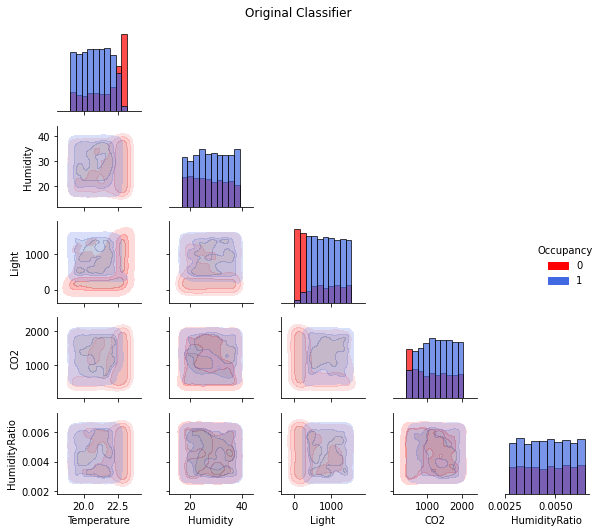

In [12]:
class_density_pairplots(visualization_original, 'Original Classifier')

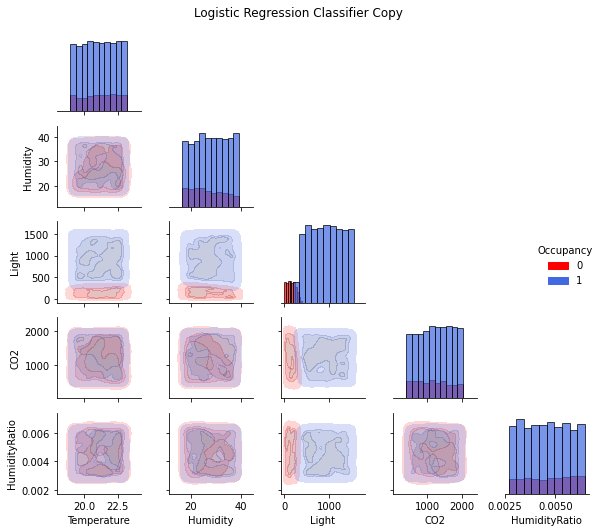

In [13]:
class_density_pairplots(visualization_log, 'Logistic Regression Classifier Copy')

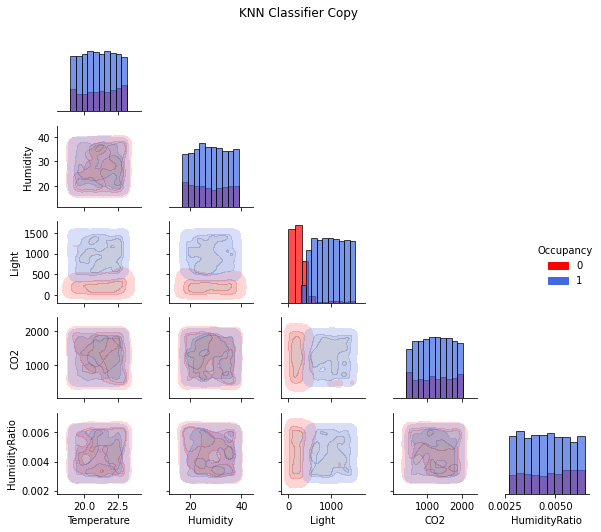

In [14]:
class_density_pairplots(visualization_knn, 'KNN Classifier Copy')

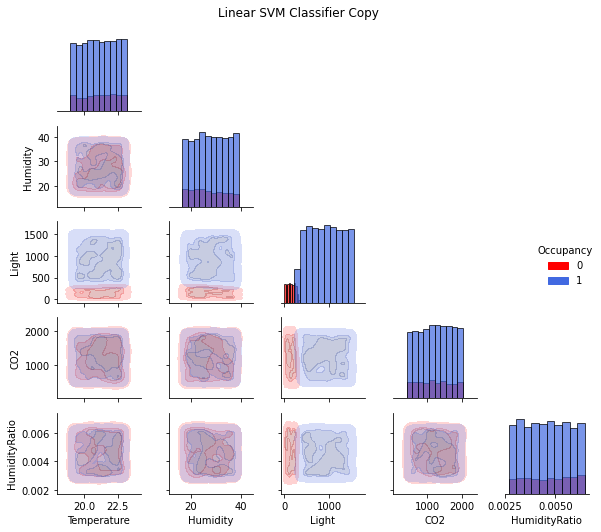

In [15]:
class_density_pairplots(visualization_svm, 'Linear SVM Classifier Copy')

#### Conclusions

* All the copies labeled a much higher percentage of events as a non-occupied room than the original classifier. 
* All the copies identified having a low light as a clear indicator of an empty room.
* None of the copies identified having a high temperature or a low amount of CO2 as a clear indicator of the room being empty, although the original model did.
* The class densities defined by the copies in projections involving the light feature, display a clear separation between them, but they are more mixed in the original classifier.

[Index](#Index)  
  
  


<a name="Densities">  


### Examples of detailed class density projections for each classifier

Here we have chosen a couple of parameters at a time and display their class densities side by side in detail for all the classifiers.

In [16]:
# We construct a number of data points and label them with the different classifiers
visualization_data = uniform_sampling(nsamples=50000, feature_parameters=feature_description)

visualization_original = labeling(visualization_data, occupancy_model.model, label_col="Occupancy")
visualization_log = labeling(visualization_data, log_normal_copy.copy, label_col="Occupancy")
visualization_knn = labeling(visualization_data, knn_normal_copy.copy, label_col="Occupancy")
visualization_svm = labeling(visualization_data, svm_normal_copy.copy, label_col="Occupancy")

In [17]:
# Common parameters
titles = ["Original Classifier", "Logistic Regression Classifier Copy", 
          "KNN Classifier Copy", "SVM Classifier Copy"]
datasets = [visualization_original.df, visualization_log.df, visualization_knn.df, visualization_svm.df]
other_kwargs = {"palette": colors}

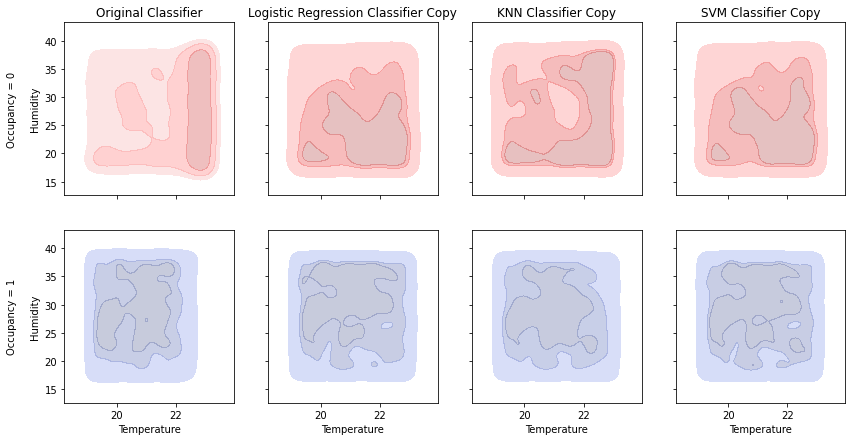

In [18]:
%%capture --no-display
feature1 = "Temperature"
feature2 = "Humidity"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, label_col="Occupancy",
                                            titles=titles, other_kwargs=other_kwargs)

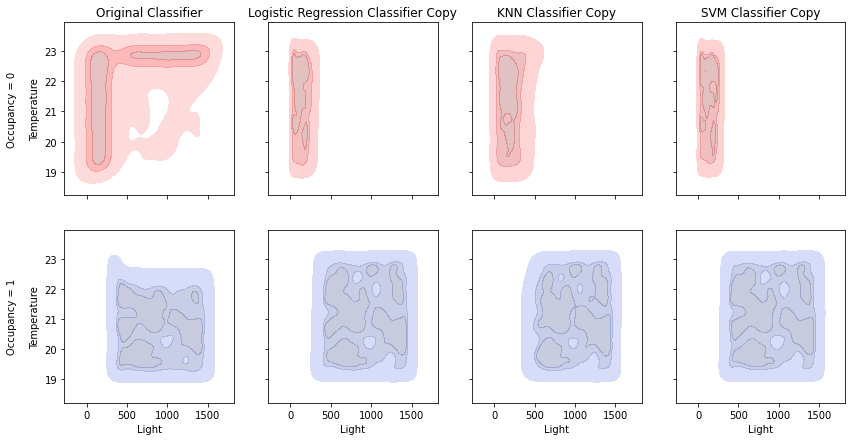

In [19]:
%%capture --no-display
feature1= "Light"
feature2= "Temperature"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, label_col="Occupancy",
                                            titles=titles, other_kwargs=other_kwargs)

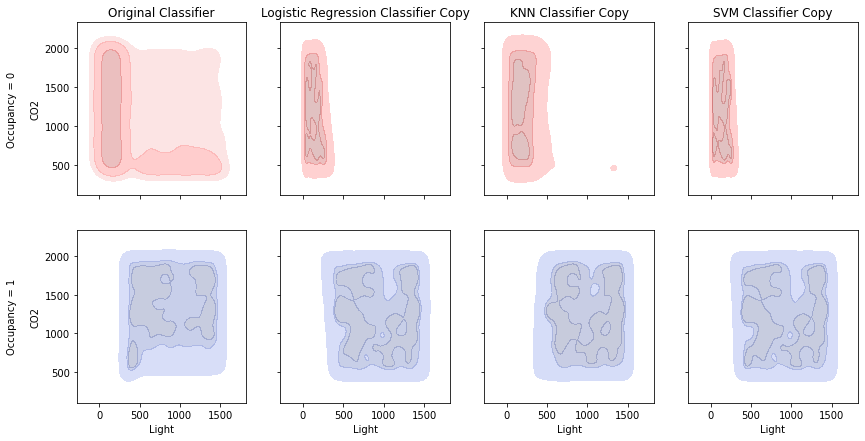

In [20]:
%%capture --no-display
feature1= "Light"
feature2= "CO2"
fig, axs = multivariable_density_comparison(datasets=datasets, feature1=feature1, feature2=feature2, label_col="Occupancy",
                                            titles=titles, other_kwargs=other_kwargs)

### Conclusions

* The original classifier seems to classify the feature space with a topology of horizontal and vertical regions.
* None of the classifier copies follows perfectly the original classifier with this amount of sampling.
* The detailed class density projections allow to realise the close resemblance between the classification carried out by the logistic regression and linear SVM classifiers, which stems from the fact that both are linear classifiers. This is in contrast with the KNN classifier copy.

[Index](#Index)  
  
  

-----
-----